[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/image_matching.ipynb)

# Image matching example with LoFTR

First, we will install everything needed:



*  fresh version of [kornia](https://github.com/kornia/kornia) for [LoFTR](https://zju3dv.github.io/loftr/)
*  fresh version of OpenCV for MAGSAC++ geometry estimation
*  [kornia_moons](https://ducha-aiki.github.io/kornia_moons) for the conversions and visualization


In [1]:
%%capture
!pip install git+https://github.com/kornia/kornia
!pip install kornia_moons
!pip install opencv-python --upgrade

Now let's download an image pair


In [2]:
%%capture
!wget https://github.com/kornia/data/raw/main/matching/kn_church-2.jpg
!wget https://github.com/kornia/data/raw/main/matching/kn_church-8.jpg

First, we will define image matching pipeline with OpenCV SIFT features. We will also use kornia for the state-of-the-art match filtering -- Lowe ratio + mutual nearest neighbor check and Pydegensac as RANSAC

In [1]:
import matplotlib.pyplot as plt
import cv2
import kornia as K
import kornia.feature as KF
import numpy as np
import torch
from kornia_moons.feature import *

def load_torch_image(fname):
    img = K.image_to_tensor(cv2.imread(fname), False).float() /255.
    img = K.color.bgr_to_rgb(img)
    return img

In [18]:
fname1 = 'kn_church-2.jpg'
fname2 = 'kn_church-8.jpg'

img1 = load_torch_image(fname1)
img2 = load_torch_image(fname2)


matcher = KF.LoFTR(pretrained='outdoor')

input_dict = {"image0": K.color.rgb_to_grayscale(img1), # LofTR works on grayscale images only 
              "image1": K.color.rgb_to_grayscale(img2)}

with torch.no_grad():
    correspondences = matcher(input_dict)

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
for k,v in correspondences.items():
    print (k)

keypoints0
keypoints1
confidence
batch_indexes


/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now let's clean-up the correspondences with modern RANSAC and estimate fundamental matrix between two images

In [20]:
mkpts0 = correspondences['keypoints0'].cpu().numpy()
mkpts1 = correspondences['keypoints1'].cpu().numpy()
H, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Finally, let's draw the matches with a function from [kornia_moons](https://ducha-aiki.github.io/kornia_moons/feature.html#draw_LAF_matches). The correct matches are in green and imprecise matches - in blue

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


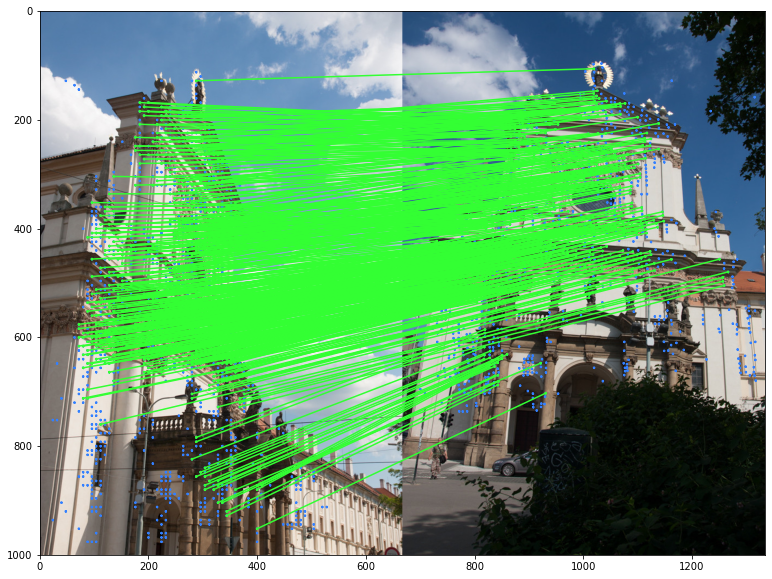

In [21]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1)),

    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
    torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={'inlier_color': (0.2, 1, 0.2),
               'tentative_color': None, 
               'feature_color': (0.2, 0.5, 1), 'vertical': False})